## Part 3 [Total: 30 points] - Solve Stock Trading Environment

Task:

In this part, you need to apply a Q-learning agent that you implemented in Part 2.1 to learn the trends in stock price and perform a series of trades over a period of time to end up with a profit. You can modify your Q-learning code, if needed.

In [ ]:
!pip install gymnasium

   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   ---- ----------------------------------- 102.4/953.9 kB 2.0 MB/s eta 0:00:01
   ----------------------------- ---------- 696.3/953.9 kB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 953.9/953.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
# Imports
import gymnasium
from gymnasium import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [ ]:
# NOTE: You can adjust the parameter 'number_of_days_to_consider'

stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=10)

### TO DO: Implement the Q-learning algorithm

In [ ]:
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
gamma = 0.95  # Discount factor
alpha = 0.15  # Learning rate
decay_rate = 0.995  # Epsilon decay rate per episode
total_episodes = 1000
max_timestamp = 10

# Initialize Q-table with zeros
qt = np.zeros((stock_trading_environment.observation_space.n, stock_trading_environment.action_space.n))

# Lists to store rewards, epsilon values, steps per episode, and penalties per episode
rewards_epi = []
epsilon_values = []
steps_per_episode = []
penalties_per_episode = []

# Training loop over episodes
for episode in range(total_episodes):
    # Reset the environment for a new episode
    state, _ = stock_trading_environment.reset()
    state_index = state  # Assuming the state is directly usable as an index
    total_rewards = 0
    total_steps = 0

    # Choose an action using epsilon-greedy strategy
    action = stock_trading_environment.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])

    while True:
        # Take a step in the environment
        next_state, reward, terminated, truncated, _ = stock_trading_environment.step(action)
        total_steps += 1
        next_strt_idx = next_state  # Assuming the state is directly usable as an index

        # Choose the next action using epsilon-greedy strategy
        next_action = stock_trading_environment.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])

        # Update Q-table using the Q-learning update rule
        qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])

        # Move to the next state and action
        state_index, action = next_strt_idx, next_action
        total_rewards += reward

        # Check if the episode is terminated or truncated
        if terminated or truncated:
            break

    # Q-table update for every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}")
        print("Q-table:")
        print(qt)

    # Update epsilon using the decay rate
    epsilon = max(epsilon_min, epsilon * decay_rate)
    epsilon_values.append(epsilon)
    rewards_epi.append(total_rewards)
    steps_per_episode.append(total_steps)

    # Print average steps for every 100 episodes
    if (episode + 1) % 100 == 0:
        average_steps = np.mean(steps_per_episode[-100:])
        print(f"Episode: {episode + 1}, Average Steps: {average_steps}")


Episode: 100
Q-table:
[[-31.9870633  -45.21306394 -33.6876846 ]
 [-43.67929859 -31.7151073  -30.71695686]
 [-35.98883942 -45.79807296 -39.08467538]
 [-47.06896287 -37.21875512 -44.15799499]]
Episode: 100, Average Steps: 393.0
Episode: 200
Q-table:
[[ -7.62066169 -24.03188748 -15.63259724]
 [-16.20563075 -10.24756123  -5.39984911]
 [-11.85278059 -23.86119667 -17.43063706]
 [-26.39002031 -16.91664432 -18.96436319]]
Episode: 200, Average Steps: 393.0
Episode: 300
Q-table:
[[23.23773896  9.09745082 18.37994456]
 [16.55430359 22.40055806 20.83510445]
 [17.50066     9.44095086 16.94126495]
 [ 8.2563531  12.8550612  11.73434525]]
Episode: 300, Average Steps: 393.0
Episode: 400
Q-table:
[[35.90912455 26.9478593  34.71061233]
 [32.29476023 35.5972779  37.87727299]
 [34.09220202 25.54207272 33.17681459]
 [29.49038201 30.89597686 27.94076596]]
Episode: 400, Average Steps: 393.0
Episode: 500
Q-table:
[[48.87745046 34.98088636 37.44049201]
 [41.28592311 40.48186918 56.54628247]
 [41.91415908 36.374

Step 2:
Save the Q-table/Policy table as a pickle file or h5 of the trained model and attach it to your assignment submission.

In [ ]:
import pickle
with open("charviku_assignment1_q_table_stock_price.pkl", 'wb') as file:
    pickle.dump(qt, file)

1. Show and discuss the results after applying the Q-learning algorithm to solve the stock trading problem. Plots should include epsilon decay and total reward per episode.

2. Provide the evaluation results. Evaluate your trained agent’s performance (you will have to set the train parameter set to False), by only choosing greedy actions from the learnt policy. Plot should include  the agent’s account value over time. Code for generating this plot is provided in the environment’s render method. Just call environment.render after termination.

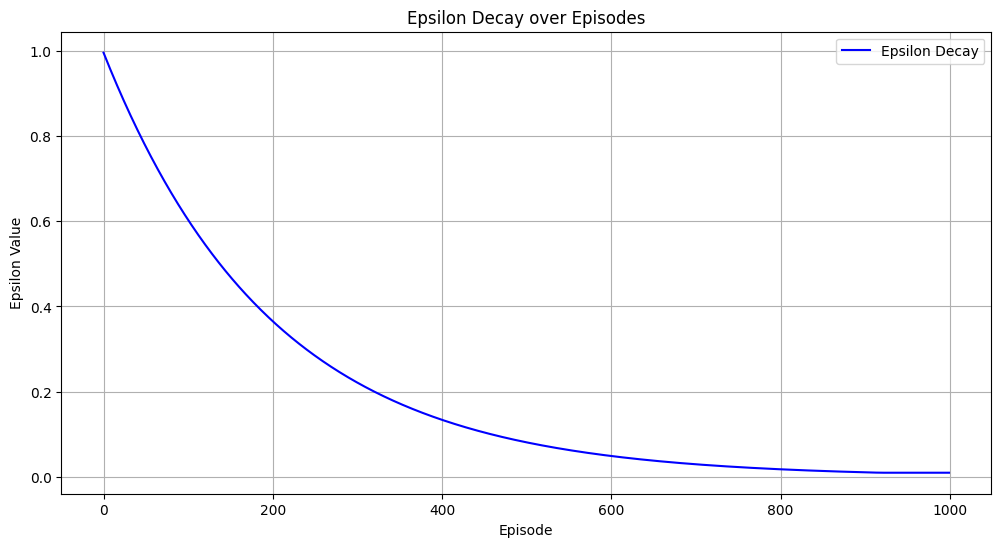

In [ ]:
# Plot epsilon decay
plt.figure(figsize=(12, 6))
plt.plot(epsilon_values, label='Epsilon Decay', color='blue')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay over Episodes')
plt.legend()
plt.grid()
plt.show()

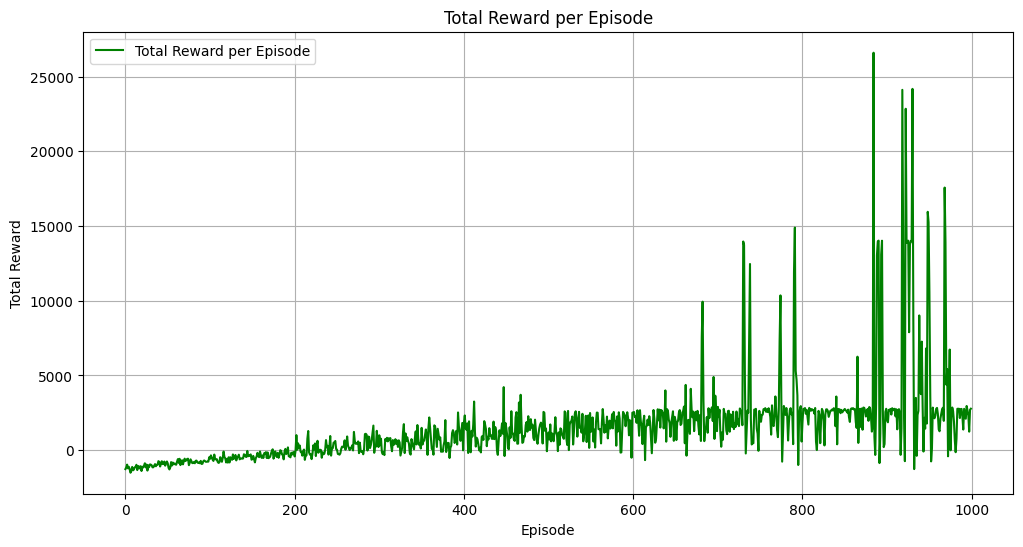

In [ ]:
# Plot total reward per episode
plt.figure(figsize=(12, 6))
plt.plot(rewards_epi, label='Total Reward per Episode', color='green')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.grid()
plt.show()

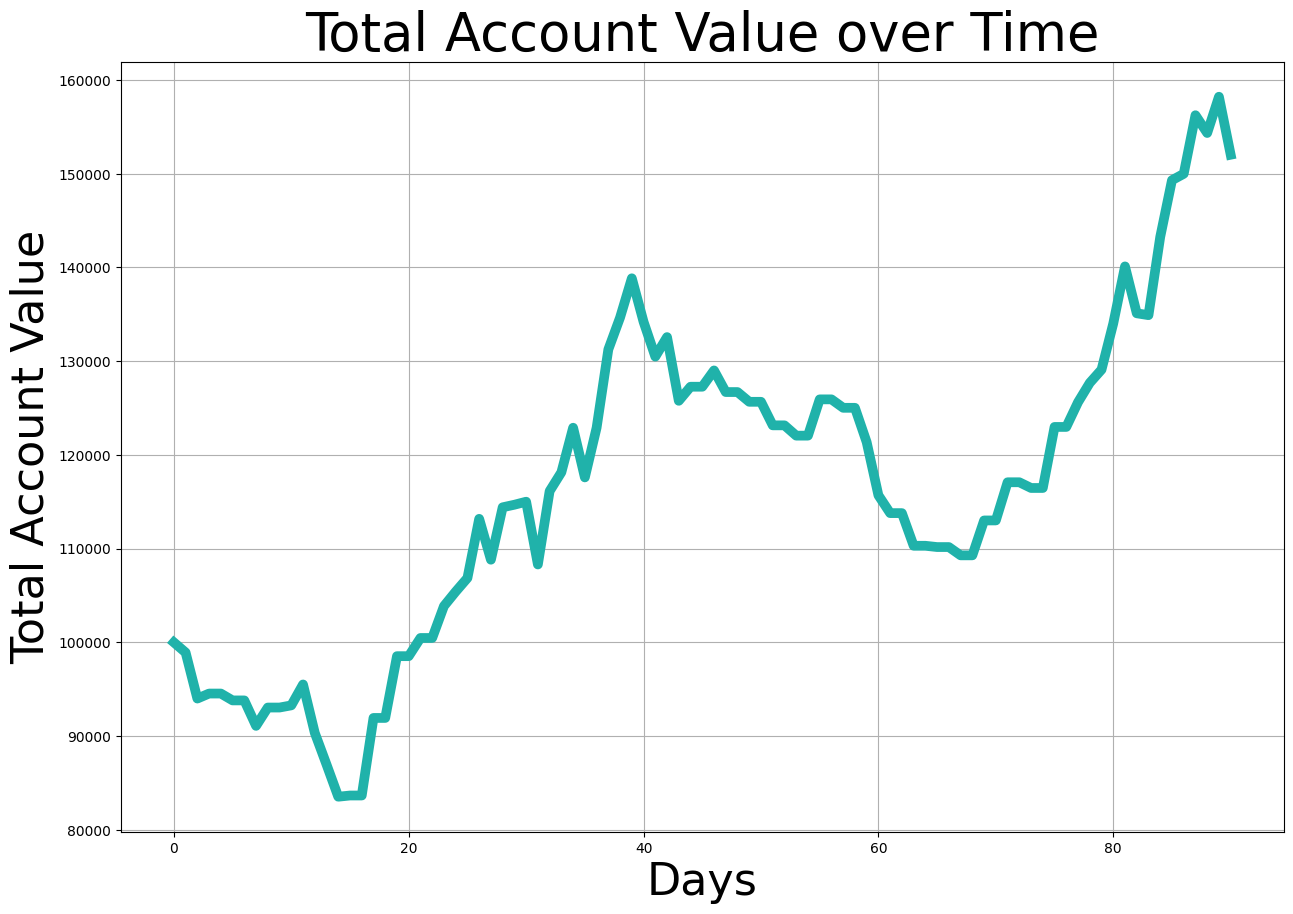

In [ ]:
stock_trading_environment.train = False
state, _ = stock_trading_environment.reset()
state_index = state
total_account_value_list_eval = []

while True:
    action = np.argmax(qt[state_index])
    next_state, reward, terminated, truncated, _ = stock_trading_environment.step(action)
    next_strt_idx = next_state
    state_index = next_strt_idx
    total_account_value_list_eval.append(stock_trading_environment.total_account_value)
    if terminated or truncated:
        stock_trading_environment.render()  # Call render to generate the plot
        break

## Extra Points [max +10 points]

### Grid-World Scenario Visualization [5 points]

Starting Position


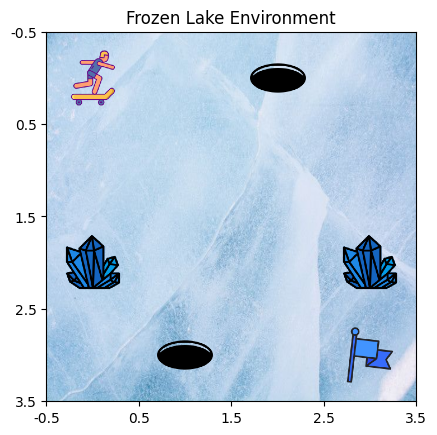

Out of the grid


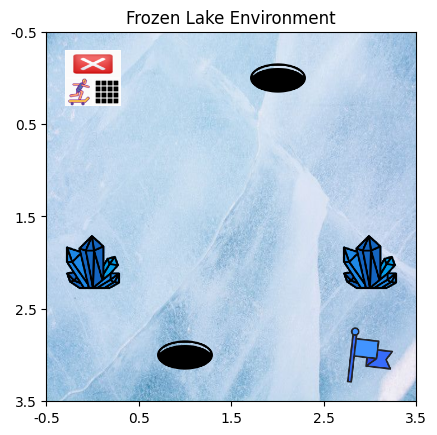

In Hole


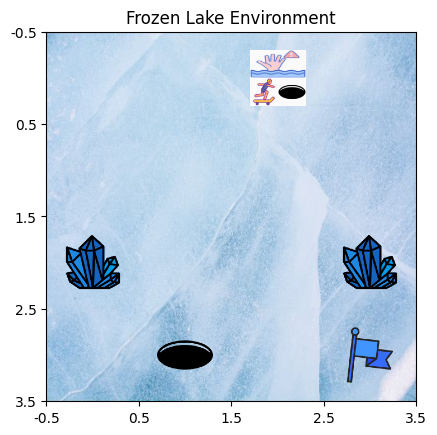

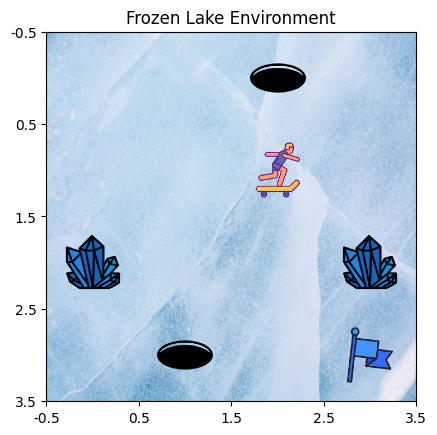

On Gems


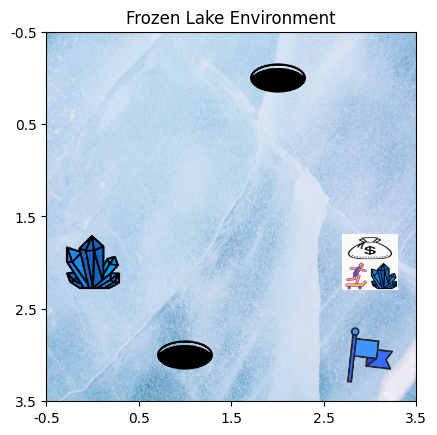

On Goal


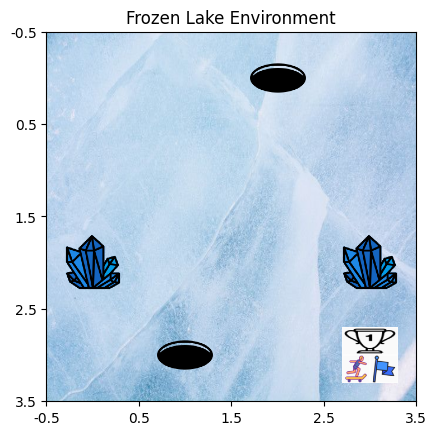

In [ ]:
# Lets display all the different states and images manually:
env_det = FrozenLakeEnv()
# Initial State
print("Starting Position")
env_det.render()

# Out of the grid
action = 1  #left
obs, reward, terminated, truncated, info = env_det.step(action)
print("Out of the grid")
env_det.render()

action = 0  #right
obs, reward, terminated, truncated, info = env_det.step(action)

# In Hole
action = 0  #right
obs, reward, terminated, truncated, info = env_det.step(action)
print("In Hole")
env_det.render()

action = 2  #up
obs, reward, terminated, truncated, info = env_det.step(action)
env_det.render()

action = 2  #up
obs, reward, terminated, truncated, info = env_det.step(action)

# On gem
action = 0  #right
obs, reward, terminated, truncated, info = env_det.step(action)
print("On Gems")
env_det.render()

# On Goal
action = 2  #up
obs, reward, terminated, truncated, info = env_det.step(action)
print("On Goal")
env_det.render()

